In [1]:
import numpy as np
from numpy import linalg as LA
import cv2
import matplotlib.pyplot as plt
import random
import sys
import math
%matplotlib inline

# Question 1)

img1 has 2211 keypoints
img2 has 2277 keypoints
two images has 1324 matches

[[  1.33866541e+00  -1.03343098e-02  -3.84224242e+02]
 [  1.34919926e-01   1.20077924e+00  -5.79766160e+01]
 [  3.55307955e-04  -1.73760401e-05   1.00000000e+00]]

 382 inliners


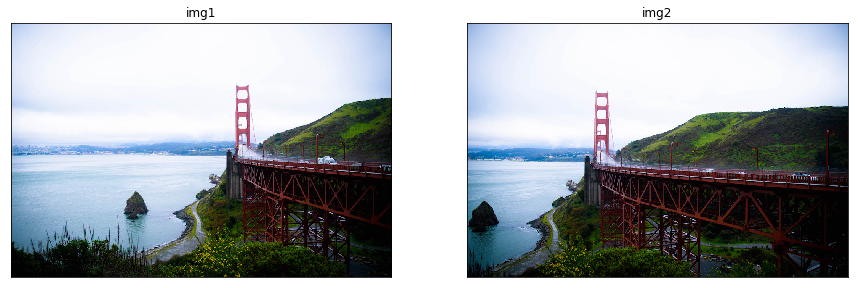

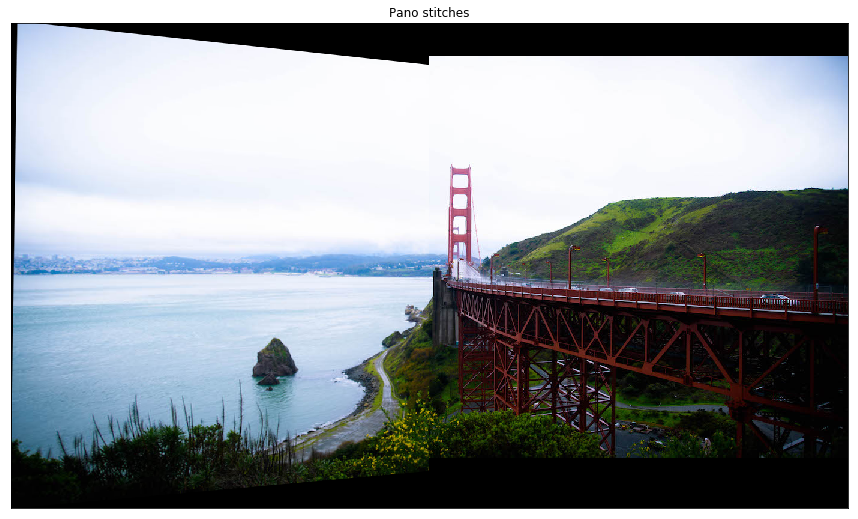

In [2]:
img1 = cv2.imread('GB1.jpg', 0) 
img2 = cv2.imread('GB2.jpg', 0)

img1_ori = cv2.imread('GB1.jpg') 
img2_ori = cv2.imread('GB2.jpg')

img1_ori = cv2.cvtColor(img1_ori, cv2.COLOR_BGR2RGB)
img2_ori = cv2.cvtColor(img2_ori, cv2.COLOR_BGR2RGB)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher( crossCheck=True)
matches = bf.match(des1,des2)

print "img1 has {} keypoints".format(len(des1))
print "img2 has {} keypoints".format(len(des2))
print "two images has {} matches\n".format(len(matches))

# Calculate homography with RANSAC
pts_src = np.float32([kp1[a.queryIdx].pt for a in matches])
pts_dst = np.float32([kp2[b.trainIdx].pt for b in matches])

H, inliners = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 1.0)
print H
print "\n {} inliners".format(len([a for a in inliners if a>0]))

# Translate
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]
pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
pts2_ = cv2.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel())
[xmax, ymax] = np.int32(pts.max(axis=0).ravel())
t = [-xmin,-ymin]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) 
    
# Creating pano
img_dst = cv2.warpPerspective(img1_ori, Ht.dot(H), (xmax-xmin, ymax-ymin))
img_dst2 = np.zeros(img_dst.shape, dtype=np.uint8)
img_dst2[t[1]:h1+t[1],t[0]:w1+t[0]] = img2_ori

# generate Gaussian pyramid for A
G = img_dst.copy()
gpA = [G]
for i in xrange(6):
    G = cv2.pyrDown(G)
    gpA.append(G)

# generate Gaussian pyramid for B
G = img_dst2.copy()
gpB = [G]
for i in xrange(6):
    G = cv2.pyrDown(G)
    gpB.append(G)

# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in xrange(5,0,-1):
    GE = cv2.pyrUp(gpA[i])
    GE = cv2.resize(GE, gpA[i-1].shape[:2][::-1])
    L = gpA[i-1]-GE
    lpA.append(L)

# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in xrange(5,0,-1):
    GE = cv2.pyrUp(gpB[i])
    GE = cv2.resize(GE, gpB[i-1].shape[:2][::-1])
    L = gpB[i-1]-GE
    lpB.append(L)

# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in xrange(1,6):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.resize(ls_, LS[i].shape[:2][::-1])
    ls_ = ls_+ LS[i]

# image with direct connecting each half
real = np.hstack((img_dst[:,:cols/2],img_dst2[:,cols/2:]))

# Didplay results
plt.figure(figsize=(15,20))
plt.subplot(121), plt.imshow(img1_ori), plt.title('img1')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2_ori), plt.title('img2')
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,20))
plt.imshow(real), plt.title('Pano stitches')
plt.xticks([]), plt.yticks([])
plt.show()



# Question2

## K-Means

generating clustered photo ...
generating clustered photo ...
generating clustered photo ...


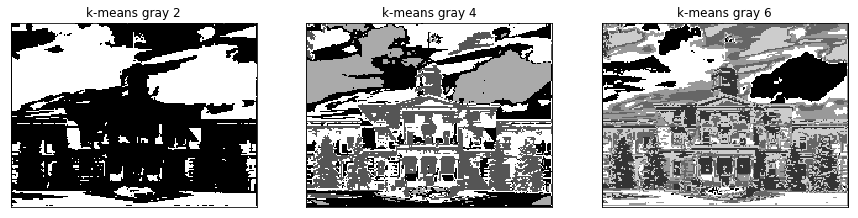

generating clustered photo ...
generating clustered photo ...
generating clustered photo ...


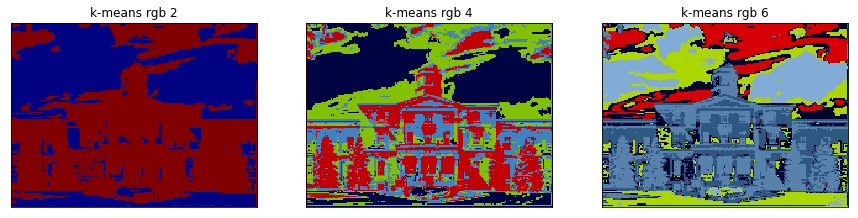

In [83]:
img_test = cv2.resize(cv2.imread('test.png'), (200,150)) 
img_test_gray = cv2.resize(cv2.imread('test.png', 0), (200, 150))

def generate_random_centroid(img, num_of_cluster):
    cluster_centers = []
    for index in xrange(num_of_cluster):
        while True:
            random_center = random.choice(img)
            if type(random_center) == np.ndarray:
                random_center = map(lambda x: int(x), random_center)
            if random_center not in cluster_centers:
                cluster_centers.append(random_center)
                break
    return cluster_centers

def reassign_cluster_for_all_points(img, cluster_centroids, clusters):
    new_clusters = [[] for _ in range(len(clusters))]
    for point_index in xrange(len(img)):
        point = img[point_index]
        min_index = 0
        min_distance = sys.maxint
        for centroid_index in xrange(len(cluster_centroids)):
            if type(point) == np.uint8 or type(point) == int:                
                point = int(point)
            else:
                point = map(lambda x: int(x), point)
 
            cluster_center = cluster_centroids[centroid_index]
            if type(cluster_center) == np.uint8 or type(point) == int:
                cluster_center = int(cluster_center)
            else:
                cluster_center = map(lambda x: int(x), cluster_center)
            temp_distance = np.sum(np.sqrt(abs(np.array(point)**2-np.array(cluster_center)**2)))
            if temp_distance < min_distance:
                min_index = centroid_index
                min_distance = temp_distance
        new_clusters[min_index].append(point_index)
    return (new_clusters, not np.array_equal(new_clusters, clusters))

def recalculate_cluster_centroids(img, clusters):
    cluster_centroids = [[] for _ in range(len(clusters))]
    for i in xrange(len(clusters)):
        cluster = clusters[i]
        cluster = map(lambda x: img[x], cluster)
        cluster_centroids[i] = np.average(np.array(cluster),axis=0)
    return cluster_centroids



def perform_k_means(img, num_of_cluster):
#     img_bk = np.copy(img)
    size = img.shape
    try:
        img.resize((size[0]*size[1], 3))
    except:
        img = img.flatten()
        
    cluster_centroids = generate_random_centroid(img, num_of_cluster)
    clusters = [[] for _ in range(num_of_cluster)]
    
    count = 0


    while True:
        sys.stdout.write('Iteration %d\r' % (count))
        sys.stdout.flush()
        count += 1
        clusters, modified = reassign_cluster_for_all_points(img, cluster_centroids, clusters)
        if not modified:
            break
        cluster_centroids = recalculate_cluster_centroids(img, clusters)

    print "generating clustered photo ..."
    img = img.reshape(size)
    paint_img = np.zeros(img.shape)
    
    color = np.arange(0,255,255/(num_of_cluster))
    if (type(img[0][0]) != np.uint8):
        color_stack = []
        for i in range(3):
            color_stack.append(np.roll(color, i))
        color = np.stack(color_stack, axis=1)

        
    color_index = 0
    for cluster in clusters:
        color_cluster = color[color_index]
        color_index += 1
        for pixel_index in cluster:
            row = pixel_index/img.shape[1]
            col = pixel_index%img.shape[1]
            paint_img[row][col] = color_cluster
    return paint_img

    
        
plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(perform_k_means(np.copy(img_test_gray), 2), cmap='gray'), plt.title('k-means gray 2')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(perform_k_means(np.copy(img_test_gray), 4), cmap='gray'), plt.title('k-means gray 4')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(perform_k_means(np.copy(img_test_gray), 6), cmap='gray'), plt.title('k-means gray 6')
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(perform_k_means(np.copy(img_test), 2)), plt.title('k-means rgb 2')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(perform_k_means(np.copy(img_test), 4)), plt.title('k-means rgb 4')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(perform_k_means(np.copy(img_test), 6)), plt.title('k-means rgb 6')
plt.xticks([]), plt.yticks([])
plt.show()

## Mean-Shift

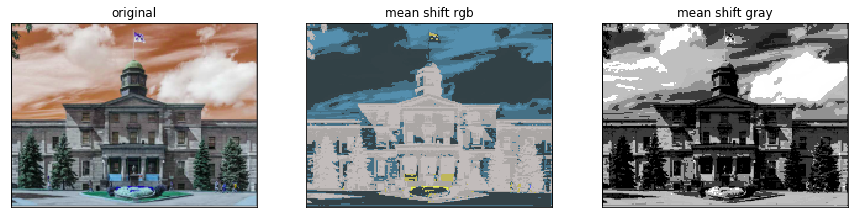

In [82]:
img_ori = cv2.resize(cv2.imread('test.png'), (200,150))
img_rgb = cv2.resize(cv2.imread('test.png'), (200,150))
img_gray = cv2.resize(cv2.imread('test.png', 0), (200,150))


def assign_clusters(img, cluster_centroids):
    clusters = [[] for _ in range(len(cluster_centroids))]
#     print img
    for pixel_index in xrange(len(img)):
        min_dist = sys.maxint
        min_index = 0
        pixel = img[pixel_index]
        
        for centroid_index in xrange(len(cluster_centroids)):
            centroid = cluster_centroids[centroid_index]
            temp_dist = np.linalg.norm(pixel-centroid)
            if temp_dist < min_dist:
                min_index = centroid_index
                min_dist = temp_dist

        clusters[min_index].append(pixel_index)
        
    return clusters

def perform_mean_shift(img_test, radius):
    size = img_test.shape
    if type(img_test[0][0]) == np.ndarray:
        img_test.resize((size[0]*size[1], 3))
    else:
        img_test = img_test.flatten()

    img_test = np.array(img_test).astype(int)
    if type(img_test[0]) == np.ndarray:
        img_test = map(lambda x: tuple(x), img_test)

    centroids = list(set(img_test))
    total_number_centroid = len(centroids)

    if type(img_test[0]) == tuple:
        img_test = map(lambda x: np.array(x), img_test)
        centroids = map(lambda x: np.array(x), centroids)
    count = 0
    visited_centroids = []
    result = []
    for centroid in centroids:
        if type(centroid) == np.ndarray:
            centroid = list(centroid)
        if centroid in visited_centroids:
            continue

        sys.stdout.write('Analyzing the image ... %d%%\r' % (int(len(visited_centroids)*100/total_number_centroid)))
        sys.stdout.flush()

        while True:
            neighbor = filter(lambda x: np.linalg.norm(centroid-x) < radius, img_test)
            try:
                visited_centroids = list(set(neighbor+visited_centroids))
            except:
                visited_centroids = neighbor+visited_centroids
                visited_centroids = map(lambda x: tuple(x), visited_centroids)
                visited_centroids = list(set(visited_centroids))
                visited_centroids = map(lambda x: list(x), visited_centroids)

            if type(centroid) == np.ndarray or type(centroid) == list:
                new_centroid = (np.mean(np.array(neighbor), axis = 0).astype(int))
            else:
                new_centroid = (int(np.array(neighbor).mean()))

    #         print centroid
            is_same = np.array_equal(centroid, new_centroid)
            if is_same:
                result.append(centroid)
                break
            if type(centroid) == np.ndarray or type(centroid) == list:
                centroid = np.copy(new_centroid)
            else:
                centroid = new_centroid

    try:
        result = list(set(result))
    except:
        result = map(lambda x: tuple(x), result)
        result = list(set(result))
        result = map(lambda x: list(x), result)

    clusters = assign_clusters(img_test, result)
    paint_img = np.zeros(size)

    color_index = 0
    for cluster in clusters:
        color_cluster = result[color_index]
        color_index += 1

        for pixel_index in cluster:
            row = pixel_index/size[1]
            col = pixel_index%size[1]
            paint_img[row][col] = color_cluster

    sys.stdout.write('                                  \r')
    sys.stdout.flush()
    return paint_img


plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(img_ori), plt.title('original')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(perform_mean_shift(img_rgb, 40)), plt.title('mean shift rgb')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(perform_mean_shift(img_gray, 15), cmap='gray'), plt.title('mean shift gray')
plt.xticks([]), plt.yticks([])
plt.show()

## Gaussian Mixture Models (EM)

[41, 165] 4
[23, 87]
generating clustered photo ...
[10, 42, 102, 194]
[3, 16, 47, 98]
generating clustered photo ...
[5, 23, 59, 118, 201]
[1, 7, 23, 53, 98]
generating clustered photo ...


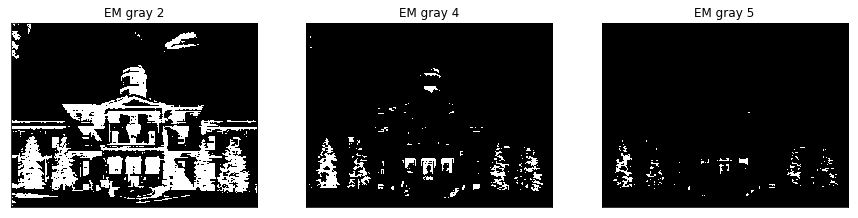

/Users/xuji/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in double_scalars


/Users/xuji/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in sqrt
/Users/xuji/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


[array(-9223372036854775808), array(-9223372036854775808)]
[array(-9223372036854775808), array(-9223372036854775808)]
generating clustered photo ...
[array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808)]
[array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808)]
generating clustered photo ...
[array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808)]
[array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808), array(-9223372036854775808)]
generating clustered photo ...


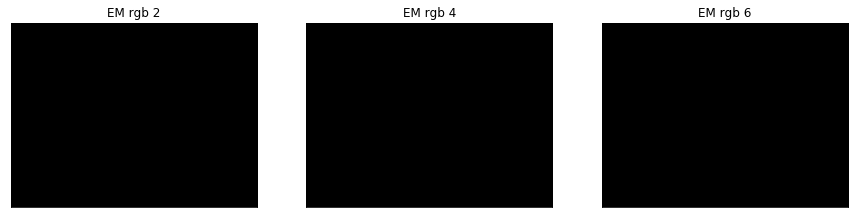

In [84]:
img_ori = cv2.resize(cv2.imread('test.png'), (400,300))
img_rgb = cv2.resize(cv2.imread('test.png'), (400,300))
img_gray = cv2.resize(cv2.imread('test.png', 0), (400,300))

def perform_EM(img, number_cluster):
    d = 1 if type(img[0][0])==np.uint8 else 3

    size = img.shape
    if type(img[0][0]) == np.ndarray:
        img.resize((size[0]*size[1], 3))
    else:
        img = img.flatten()

    img = np.array(img).astype(int)
    P = lambda x, mu, var: (1./np.sqrt(2*math.pi*var)*np.exp(-np.square(x-mu)/(2*var)))

    if type(img[0]) == np.ndarray:
        img = map(lambda x: tuple(x), img)

    distince_points = list(set(img))

    if type(img[0]) == tuple:
        img = map(lambda x: np.array(x), img)
        distince_points = map(lambda x: np.array(x), distince_points)
    count = 0

    # init mean and variance
    mean = []
    variance = []
    R = []
    for i in xrange(number_cluster):
        temp_mean = random.randint(0,255)
        temp_variance = random.randint(1,200)
        if d == 1:
            mean.append(temp_mean)
            variance.append(temp_variance)
        else:
            mean.append([temp_mean, temp_mean, temp_mean])
            variance.append([temp_variance, temp_variance, temp_variance])

    while True:
        count += 1
        sys.stdout.write('Iteration %d\r' % (count))
        sys.stdout.flush()
        new_mean_list = []
        new_variance_list = []
        for point in distince_points:
            probs = map(lambda i: P(np.array(point), np.array(mean[i]), np.array(variance[i])), xrange(number_cluster))
            try:
                probs = map(lambda x: 1 if x == float('Inf') else x, probs)
                probs = map(lambda x: x/np.sum(probs), probs)
            except:
                probs = np.array(probs)
                temp_size = probs.shape
                probs = probs.flatten()
                probs = map(lambda x: 1 if x == float('Inf') else x, probs)
                probs = np.array(probs)
                probs.reshape(temp_size)
                probs = map(lambda x: x/np.sum(probs), probs)
            R.append(probs)

        for i in xrange(number_cluster):
            cluster_weight = np.array([row[i] for row in R])
            try:
                new_mean = np.sum(np.array(cluster_weight)*np.array(distince_points))/np.sum(cluster_weight)
                new_variance = np.std(cluster_weight*distince_points)
                new_mean_list.append(int(new_mean))
                new_variance_list.append(int(new_variance))
            except:
                new_mean = np.sum(np.array(cluster_weight)[:, None]*np.array(distince_points))/np.sum(cluster_weight)
                new_variance = np.std(np.array(cluster_weight)[:, None]*np.array(distince_points))
                new_mean_list.append(np.array(new_mean).astype(int))
                new_variance_list.append(np.array(new_variance).astype(int))
        new_mean_list.sort()
        new_variance_list.sort()
        if np.array_equal(new_mean_list, mean) and np.array_equal(new_variance_list, variance):
            break
        mean = list(new_mean_list)
        variance = list(new_variance_list)
        R=[]

    print mean
    print variance
    paint_img = np.zeros(size)
    color = np.arange(0,255,255/(number_cluster))

    img = np.array(img).reshape(size)
    print "generating clustered photo ..."
    for row in xrange(paint_img.shape[0]):
        for col in xrange(paint_img.shape[1]):
            probs = map(lambda i: P(img[row][col], mean[i], variance[i]), xrange(number_cluster))
            color_index = np.argmin(probs)
            paint_img[row][col] = color[color_index]
    return paint_img

plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(perform_EM(np.copy(img_gray), 2), cmap='gray'), plt.title('EM gray 2')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(perform_EM(np.copy(img_gray), 4), cmap='gray'), plt.title('EM gray 4')
plt.xticks([]), plt.yticks([])

# doesn't converge at 6
plt.subplot(133), plt.imshow(perform_EM(np.copy(img_gray), 5), cmap='gray'), plt.title('EM gray 5')
plt.xticks([]), plt.yticks([])
plt.show()


plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(perform_EM(np.copy(img_rgb), 2)), plt.title('EM rgb 2')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(perform_EM(np.copy(img_rgb), 4)), plt.title('EM rgb 4')
plt.xticks([]), plt.yticks([])

# doesn't converge at 6
plt.subplot(133), plt.imshow(perform_EM(np.copy(img_rgb), 6)), plt.title('EM rgb 6')
plt.xticks([]), plt.yticks([])
plt.show()

# ======================================================
# In terms of clustering, Mean shift on RGB gives me the best result, but it's also the slowest. EM on grayscale is fast and gives a fair result